In [110]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt

transform = transforms.Compose([
                                transforms.ToTensor()
                                ])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [111]:
BATCH_SIZE = 128
NOISE_DIMENSION = 96

def sample_random_noise(batch_size, dim):
    return 2 * torch.rand((batch_size, dim)) - 1

In [112]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x.reshape(-1, 784)
        return self.model(x)

In [113]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(NOISE_DIMENSION, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

In [114]:
def bce_loss(input, target):
    neg_abs = - input.abs()
    loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
    return loss.mean()

def discriminator_loss(logits_real, logits_fake):
    loss = None
    N = logits_real.size()
    targets = torch.ones((N))
    
    loss = bce_loss(logits_real, targets) + bce_loss(logits_fake, 1 - targets)
    
    return loss

def generator_loss(logits_fake):
    loss = None
    N = logits_fake.size()
    targets = torch.ones((N))
    
    loss = bce_loss(logits_fake, targets)
    return loss

In [115]:
def get_optimizer(model):
    optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))
    return optimizer

### Show Images

In [116]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

In [117]:
def run(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=BATCH_SIZE, noise_size=NOISE_DIMENSION, num_epochs=10):
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_loader:
            if len(x) != batch_size:
                continue
            D_solver.zero_grad()
            real_data = x
            logits_real = D(2* (real_data - 0.5))

            g_fake_seed = sample_random_noise(batch_size, noise_size)
            fake_images = G(g_fake_seed)
            logits_fake = D(fake_images.view(batch_size, 1, 28, 28))

            d_total_error = discriminator_loss(logits_real, logits_fake)
            d_total_error.backward()        
            D_solver.step()

            G_solver.zero_grad()
            g_fake_seed = sample_random_noise(batch_size, noise_size)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images.view(batch_size, 1, 28, 28))
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
                imgs_numpy = fake_images.data.cpu().numpy()
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

In [118]:
D = Discriminator()
G = Generator()

D_solver = get_optimizer(D)
G_solver = get_optimizer(G)

Iter: 0, D: 1.376, G:0.7048


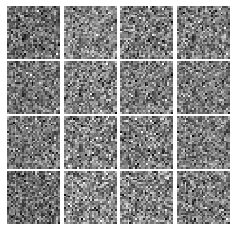


Iter: 250, D: 1.124, G:1.286


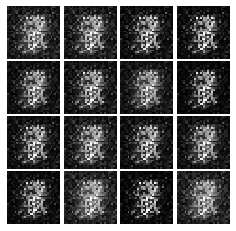


Iter: 500, D: 1.054, G:1.368


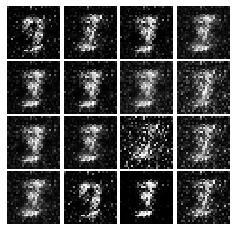


Iter: 750, D: 0.9618, G:1.486


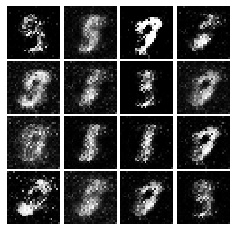


Iter: 1000, D: 1.251, G:0.8339


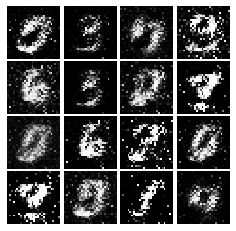


Iter: 1250, D: 1.371, G:1.378


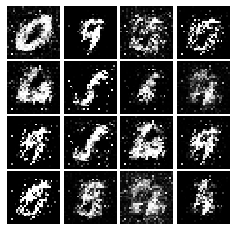


Iter: 1500, D: 1.131, G:0.9467


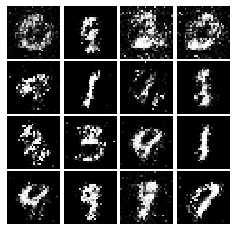


Iter: 1750, D: 1.295, G:1.327


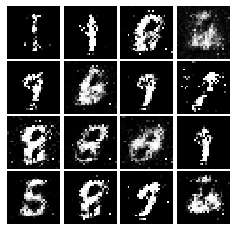


Iter: 2000, D: 1.276, G:0.9762


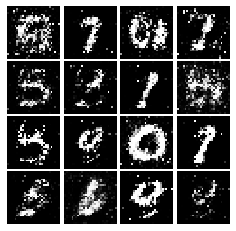


Iter: 2250, D: 1.409, G:0.9914


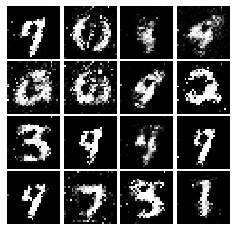


Iter: 2500, D: 1.377, G:0.7488


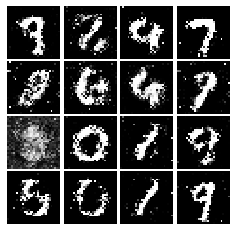


Iter: 2750, D: 1.306, G:0.8282


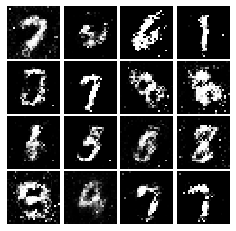


Iter: 3000, D: 1.293, G:0.8635


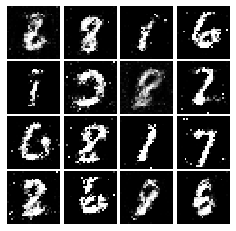


Iter: 3250, D: 1.252, G:0.9862


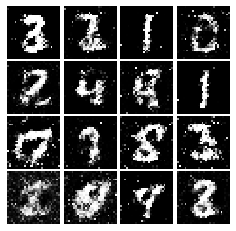


Iter: 3500, D: 1.379, G:0.8636


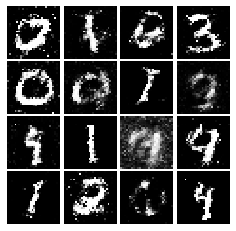


Iter: 3750, D: 1.357, G:0.8051


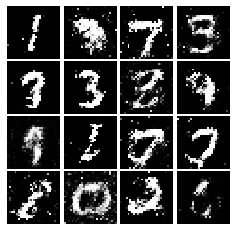


Iter: 4000, D: 1.321, G:0.784


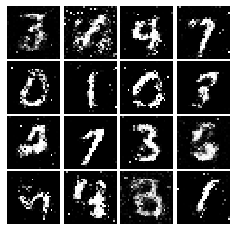


Iter: 4250, D: 1.209, G:0.7862


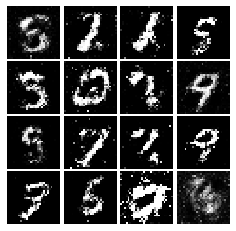

KeyboardInterrupt: 

In [119]:
run(D, G, D_solver, G_solver, discriminator_loss, generator_loss)